### RAG with **Weaviate** Vector Storage Cookbook

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1U5ahH6s0y76k4LsV4tM9F7tICfzvYYlg?usp=sharing).

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>

In this notebook, we show the usage of `CAMEL` agents generating accurate, context-aware responses (RAG) using `OPENAI` text embeddings stored in a cloud-hosted weaviate vector storage.

The workflow is as following:
1. We start a `weaviate` storage instance.  
1. We get a document, divide it into chunks using `unstructured` which are further converted into vectors using `OpenAIEmbedding`. This processing is handled by `CAMEL`'s `VectorRetriever`.
2. Upon a user query, the query is processed through the database to fetch the `top k` chunks that cross a similarity threshold. This fetch gives us our retrieved context.
3. The retrieved context, along with the orignal user query is provided to a CAMEL `ChatAgent` for generating a high fidelity response.

### To begin, let's go through the installations

In [1]:
!pip install camel-ai "unstructured[pdf]" weaviate-client protobuf==6.31.1 --q

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.


### Credentials

This could be done in three different ways.

1. To load the API keys as password, use the first option.
2. To use the API keys as stored as Google `Colab` secrets, use the second option.
3. To use the API keys as stored in the local environment file `.env`, use the third option.

#### Let's get the API keys required.
We need `OPENAI` and `WEAVIATE` API keys. Additionally, we would need the `url` to the `WEAVIATE` storage.

To create the `WEAVIATE` database, go to the [Weaviate Cloud console](https://console.weaviate.cloud/) and create a free Sandbox instance.

Now you can connect to your Weaviate instance. You will need the:

`REST Endpoint URL` and the
`Administrator API` Key.
You can retrieve them both from the [WCD console](https://console.weaviate.cloud/) as shown below:

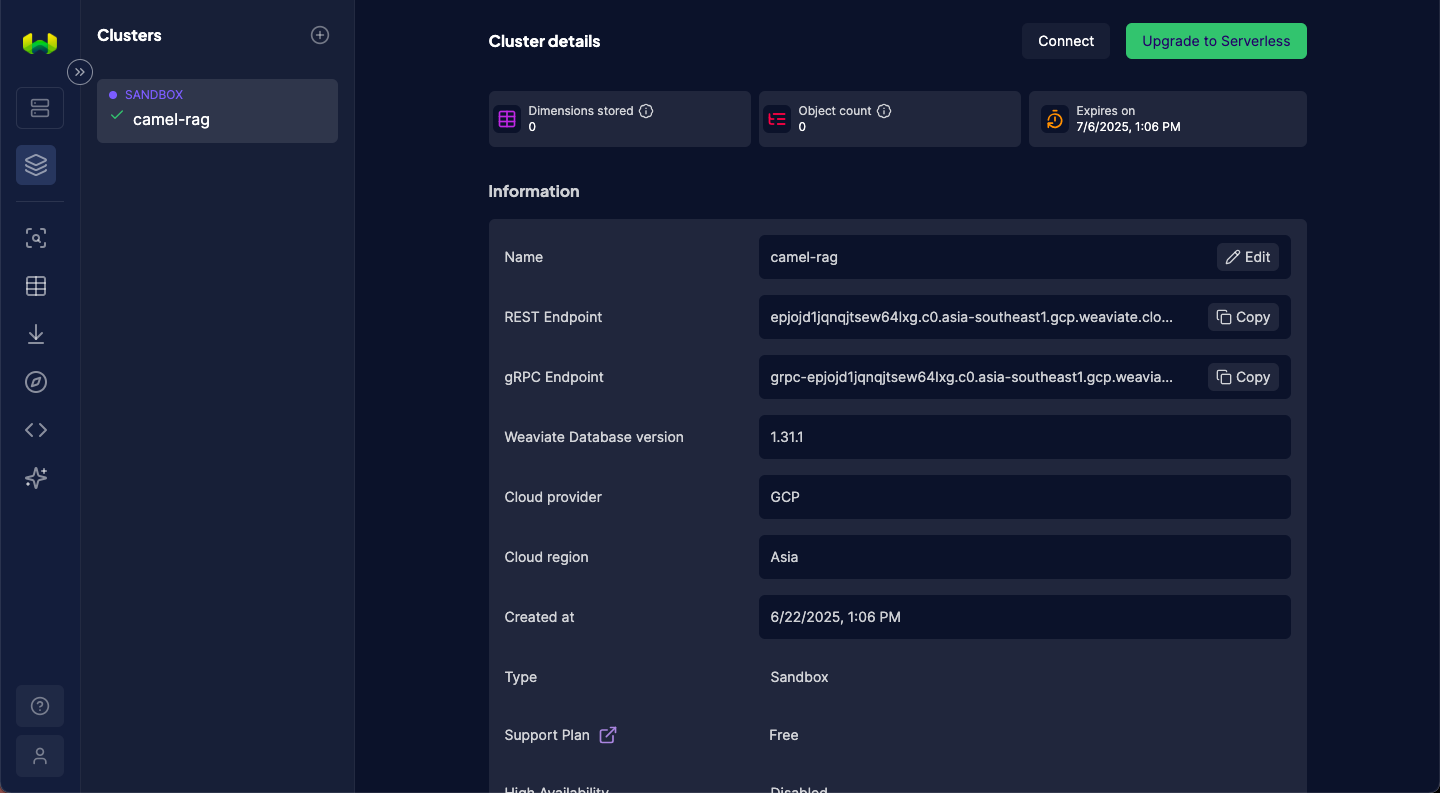

Additionally, you could get your **OPENAI API key** from [OPENAI key page](https://platform.openai.com/api-keys).

In [2]:
# # == Option 1 ==

# from getpass import getpass
# # Prompt for the OpenAI API key securely
# openai_api_key = getpass('Enter your API key: ')
# os.environ["OPENAI_API_KEY"] = openai_api_key

# weaviate_api_key = getpass('Enter your WEAVIATE API key: ')
# os.environ["WEAVIATE_API_KEY"] = weaviate_api_key

In [4]:
# == Option 2 ==

import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["WEAVIATE_API_KEY"] = userdata.get("WEAVIATE_API_KEY")

In [ ]:
# # == Option 3 ==
# from dotenv import load_dotenv
# import os

# load_dotenv()

In [5]:
# Replace with your own database url
WEAVIATE_URL = "epjojd1jqnqjtsew64lxg.c0.asia-southeast1.gcp.weaviate.cloud"

### Load Data
Let’s first load the CAMEL paper from https://arxiv.org/pdf/2303.17760.pdf. This will be our local example data.

In [6]:
import os
import requests

os.makedirs('local_data', exist_ok=True)

url = "https://arxiv.org/pdf/2303.17760.pdf"
response = requests.get(url)
with open('local_data/camel_paper.pdf', 'wb') as file:
     file.write(response.content)

In [7]:
# Embeddings
from camel.embeddings import OpenAIEmbedding
from camel.types import EmbeddingModelType

embedding_instance = OpenAIEmbedding(model_type=EmbeddingModelType.TEXT_EMBEDDING_3_LARGE)

### Let's now setup our database

In [8]:
# Weaviate Storage
from camel.storages import WeaviateStorage

storage_instance = WeaviateStorage(
    vector_dim=embedding_instance.get_output_dim(),
    collection_name="camel_paper",
    connection_type="cloud",
    wcd_cluster_url=WEAVIATE_URL,
    wcd_api_key=os.environ["WEAVIATE_API_KEY"],
    # Vector index configuration
    vector_index_type="hnsw",
    distance_metric="cosine",
)

In [9]:
# Check the connection and database status

status = storage_instance.status()
status

VectorDBStatus(vector_dim=3072, vector_count=0)

Import and set the retriever instance.

In [10]:
from camel.retrievers import VectorRetriever

vector_retriever = VectorRetriever(embedding_model=embedding_instance,
                                   storage=storage_instance)

The content is automatically divided into small **chunks** using the integrated `Unstructured` Module's chunk_by_title function. Each chunk is limited to a maximum of 500 characters, a size suitable for `OpenAI Embedding`. The text from these chunks will then be embedded and stored in the vector storage. This operation will require some time to complete.

All these steps are handled by `VectorRetriever` automatically.

In [11]:
vector_retriever.process(
    content="local_data/camel_paper.pdf",
)

The database is now populated. Let's again verify it.

In [12]:
status = storage_instance.status()
status

VectorDBStatus(vector_dim=3072, vector_count=585)

Now we can retrieve information from the vector storage by giving a query. By default it will give you back the text content from top 1 chunk with highest Cosine similarity score, and the similarity score should be higher than 0.75 to ensure the retrieved content is relevant to the query. You can also change the `top_k` value and `similarity_threshold` value with your needs.

The returned dictionary list includes:

* similarity score
* content path
* metadata
* text

### Let's now verify that our the vector database is working as expected

First, a query relevant to the paper.

In [13]:
retrieved_info = vector_retriever.query(
    query="To address the challenges of achieving autonomous cooperation, we propose a novel communicative agent framework named role-playing .",
    top_k=1
)
print(retrieved_info[0]['text'])

6 Conclusion In this paper, we explore the potential of autonomous cooperation among communicative agents and propose a novel cooperative agent framework named role-playing . Our approach enables communicative agents to collaborate autonomously toward completing tasks while requiring minimal human intervention, leading to better solutions are per our thorough evaluations. Through our analysis, we show that achieving autonomous cooperation is challenging due to issues like conversation deviation,


Now, an irrelevant query.

In [14]:
retrieved_info_irrevelant = vector_retriever.query(
    query="Compared with dumpling and rice, which should I take for dinner?",
    top_k=1,
)

print(retrieved_info_irrevelant)

[{'text': 'No suitable information retrieved from local_data/camel_paper.pdf with similarity_threshold = 0.7.'}]


### Let's setup our agent

In [15]:
assistant_sys_msg = """You are a helpful assistant to answer question,
I will give you the Original Query and Retrieved Context,
answer the Original Query based on the Retrieved Context,
if you can't answer the question just say I don't know."""

In [16]:
from camel.types import TaskType, ModelType, ModelPlatformType
from camel.configs import ChatGPTConfig
from camel.models import ModelFactory

model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_4O_MINI,
    model_config_dict=ChatGPTConfig(temperature=0.0).as_dict(), # [Optional] the config for model
)

In [17]:
from camel.agents import ChatAgent
rag_agent = ChatAgent(system_message=assistant_sys_msg, model=model)

To see the effects of RAG, let's look at a non-RAG output.

In [18]:
non_rag_agent = ChatAgent(system_message="You are a helpful agent", model=model)
non_rag_response = non_rag_agent.step("Who are the authors of the 'CAMEL: Communicative Agents for Mind Exploration of Large Language Model Society' paper?")
non_rag_response.msgs[0].content

'The authors of the paper titled "CAMEL: Communicative Agents for Mind Exploration of Large Language Model Society" are:\n\n1. Shikhar Bahl\n2. Shubham Soni\n3. Shubham Kumar\n4. Abhishek Kumar\n5. Raghavendra Prasad\n6. Raghavendra Prasad\n\nIf you need more information about the paper or its content, feel free to ask!'

This is of course a wrong information. Not ideal, indeed.

Now, let's look at a RAG output.

In [19]:
def ask_assistant(query):
  retrieved_info = vector_retriever.query(
      query=query,
      top_k=1,
      similarity_threshold=0.5
  )
  # Pass the retrieved info and the original query to the agent
  user_msg = str({'query': query,
              'retrieved context': retrieved_info[0]['text']})

  # Get response
  rag_response = rag_agent.step(user_msg)
  print(rag_response.msgs[0].content)
  rag_agent.reset()

In [20]:
query = "Who are the authors of the 'CAMEL: Communicative Agents for Mind Exploration of Large Language Model Society' paper?"
ask_assistant(query)

The authors of the paper "CAMEL: Communicative Agents for Mind Exploration of Large Language Model Society" are Guohao Li, Hasan Abed Al Kader Hammoud, Hani Itani, Dmitrii Khizbullin, and Bernard Ghanem.


This is indeed correct information.

Let's now ask something that is related to CAMEL but isn't in the paper.

In [21]:
query = "If I'm interest in contributing to the CAMEL project, what should I do?"
ask_assistant(query)

I don't know.


As expected, the assistant couldn't retrieve anything useful and as directed in the prompt, it says it doesn't know the answer.

### Let's now clean up the storage and close the connection explicitly.

In [22]:
# Clear all vectors when done
print("\nClearing all vectors...")
storage_instance.clear()
status = storage_instance.status()
print(f"Vector count after clearing: {status.vector_count}")

# Close connection explicitly
storage_instance.close()
print("Connection closed.\n")


Clearing all vectors...
Vector count after clearing: 0
Connection closed.



That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:

1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)

2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)

4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)

5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>
